In [1]:
import numpy as np
import sys, os
cwd_split = os.getcwd().split(os.sep)
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")

import mitsuba as mi
# mi.set_variant("cuda_ad_rgb")
mi.set_variant('llvm_ad_rgb')
import drjit as dr
import matplotlib.pyplot as plt
def plot_list(images, title=None):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    if title is not None:
        plt.suptitle(title)

from gaussnewton_test import conjugate_gradient, AlbedoScene

In [2]:
scene = mi.load_file('./tutorials/scenes/cbox.xml', res=128, integrator='prb')
image_ref = mi.render(scene, spp=512)

params = mi.traverse(scene)
print(params['light.emitter.radiance.value'])

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

[[18.386999130249023, 13.987299919128418, 6.753570079803467]]


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [3]:
color_sample = dr.linspace(mi.Float, 0, 1, 5)
radiance_sample = dr.linspace(mi.Float, 0, 30, 5)
print(color_sample)

params = mi.traverse(scene)
print(type(params['light.emitter.radiance.value']))
params_gd = mi.traverse(scene)

key = 'red.reflectance.value'
keys = ['red.reflectance.value', 'light.emitter.radiance.value'] #'green.reflectance.value', 
# param_ref = mi.Color3f(params[key])
# Set another color value and update the scene
# params[key] = mi.Color3f(0.01, 0.2, 0.9)
# params.update();

# TODO
param_ref = []
# Save the original value
for i in range(len(keys)):
    param_ref.append(mi.Color3f(params[keys[i]]))

# for key in keys:
#     params[key] = mi.Color3f(0.01, 0.2, 0.9)
params[keys[0]] = mi.Color3f(0.01, 0.2, 0.9)
params[keys[1]] = mi.Color3f(30, 1, 0.1)

params.update();

image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

[0.0, 0.25, 0.5, 0.75, 1.0]
<class 'mitsuba.cuda_ad_rgb_double.Color3f'>


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [4]:
# opt = mi.ad.Adam(lr=0.05)
# opt[key] = params[key]
# params.update(opt);

keys_opt = {'red.reflectance.value', 'light.emitter.radiance.value'} #'green.reflectance.value', 
experiment_idx = -2
sc = AlbedoScene(scene, params,  keys_opt, ref_images = image_ref, _EXP_IDX = experiment_idx)

def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

iteration_count = 10
errors = []
err_ref_init = dr.sum(dr.sqr(param_ref[0] - params[keys[0]] + param_ref[1] - params[keys[1]]))
errors.append(err_ref_init)

image, loss = sc.eval_func()
for it in range(iteration_count):
    
    descent_dir = conjugate_gradient(sc.values(), loss, sc)
    
    sc.step(descent_dir)
    
    image, loss = sc.eval_func()
    
    # # Perform a (noisy) differentiable rendering of the scene
    # image = mi.render(scene, params, spp=4)

    # # Evaluate the objective function from the current rendered image
    # loss = mse(image)

    # # Backpropagate through the rendering process
    # dr.backward(loss)

    # # Optimizer: take a gradient descent step
    # opt.step()

    # # Post-process the optimized parameters to ensure legal color values.
    # opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # # Update the scene state to the new optimized values
    # params.update(opt)

    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref[0] - params[keys[0]] + param_ref[1] - params[keys[1]]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

image_final = mi.render(scene, spp=128)
print(params[keys[0]])
print(params[keys[1]])
mi.util.convert_to_bitmap(image_final)

Iteration 09: parameter error = 0.0614578
Optimization complete.
[[0.6012490815664763, 0.05126618211559693, 0.3272958428399374]]
[[18.439323883362118, 13.92991168807117, 6.69883233863802]]


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

[0.06812491435113277]
[0.061457062460645084]


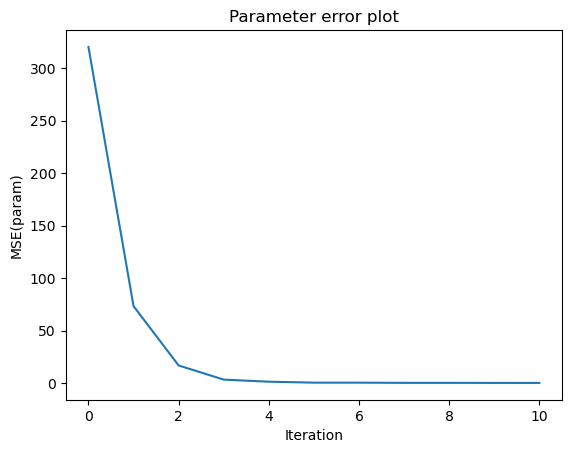

In [5]:
import matplotlib.pyplot as plt
print(errors[iteration_count - 1])
print(dr.min(errors))
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()

In [6]:
# Set another color value and update the scene
params_gd[keys[0]] = mi.Color3f(0.01, 0.2, 0.9)
params_gd[keys[1]] = mi.Color3f(30, 1, 0.1)

params_gd.update();

image_init_gd = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init_gd)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [7]:
opt = mi.ad.Adam(lr=0.05)
opt[keys[0]] = params_gd[keys[0]]
opt[keys[1]] = params_gd[keys[1]]

params_gd.update(opt);

def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

errors_orig = []
err_ref_init = dr.sum(dr.sqr(param_ref[0] - params_gd[keys[0]] + param_ref[1] - params_gd[keys[1]]))
errors_orig.append(err_ref_init)
iteration_count_base = 150
for it in range(iteration_count_base):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params_gd, spp=4)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[keys[0]] = dr.clamp(opt[keys[0]], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params_gd.update(opt)

    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref[0] - params_gd[keys[0]] + param_ref[1] - params_gd[keys[1]]))
    #err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors_orig.append(err_ref)
print('\nOptimization complete.')

image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Iteration 149: parameter error = 58.9766584
Optimization complete.


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

[282.02766534207484]
[0.061457062460645084]


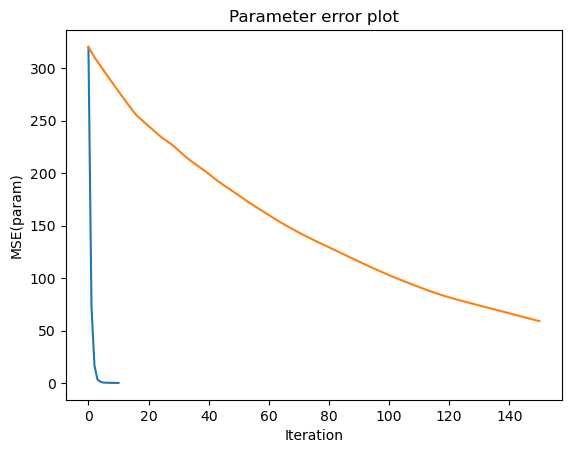

151


In [8]:
import matplotlib.pyplot as plt
print(errors_orig[iteration_count - 1])
print(dr.min(errors))
plt.plot(errors)
plt.plot(errors_orig)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
#plt.yscale('log')
plt.show()
print(len(errors_orig))

In [9]:
print(params['light.emitter.radiance.value'])
params['light.emitter.radiance.value'] = mi.Color3f(18, 3, 3)
params.update()
image = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image)

[[23.597489286036083, 7.534368490399478, 5.533152494740416]]


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [10]:
print(params['white.reflectance.value'])

[[0.8858090043067932, 0.6988589763641357, 0.6664220094680786]]


In [11]:

# scene_dict = {
#         'type': 'scene',
#         'integrator': {
#             'type': 'path',
#             'max_depth': 8
#         },
#         # -------------------- Sensor --------------------
#         'sensor': {
#             'type': 'perspective',
#             'fov_axis': 'smaller',
#             'near_clip': 0.001,
#             'far_clip': 100.0,
#             'focus_distance': 1000,
#             'fov': 39.3077,
#             'to_world': T.look_at(
#                 origin=[0, 0, 3.90],
#                 target=[0, 0, 0],
#                 up=[0, 1, 0]
#             ),
#             'sampler': {
#                 'type': 'independent',
#                 'sample_count': 64
#             },
#             'film': {
#                 'type': 'hdrfilm',
#                 'width' : 256,
#                 'height': 256,
#                 'rfilter': {
#                     'type': 'gaussian',
#                 },
#                 'pixel_format': 'rgb',
#                 'component_format': 'float32',
#             }
#         },
#         # -------------------- BSDFs --------------------
#         'white': {
#             'type': 'diffuse',
#             'reflectance': {
#                 'type': 'rgb',
#                 'value': [0.885809, 0.698859, 0.666422],
#             }
#         },
#         'green': {
#             'type': 'diffuse',
#             'reflectance': {
#                 'type': 'rgb',
#                 'value': [0.105421, 0.37798, 0.076425],
#             }
#         },
#         'red': {
#             'type': 'diffuse',
#             'reflectance': {
#                 'type': 'rgb',
#                 'value': [0.570068, 0.0430135, 0.0443706],
#             }
#         },
#         # -------------------- Light --------------------
#         'light': {
#             'type': 'rectangle',
#             'to_world': T.translate([0.0, 0.99, 0.01]).rotate([1, 0, 0], 90).scale([0.23, 0.19, 0.19]),
#             'bsdf': {
#                 'type': 'ref',
#                 'id': 'white'
#             },
#             'emitter': {
#                 'type': 'area',
#                 'radiance': {
#                     'type': 'rgb',
#                     'value': [18.387, 13.9873, 6.75357],
#                 }
#             }
#         },
#         # -------------------- Shapes --------------------
#         'floor': {
#             'type': 'rectangle',
#             'to_world': T.translate([0.0, -1.0, 0.0]).rotate([1, 0, 0], -90),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'white'
#             }
#         },
#         'ceiling': {
#             'type': 'rectangle',
#             'to_world': T.translate([0.0, 1.0, 0.0]).rotate([1, 0, 0], 90),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'white'
#             }
#         },
#         'back': {
#             'type': 'rectangle',
#             'to_world': T.translate([0.0, 0.0, -1.0]),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'white'
#             }
#         },
#         'green-wall': {
#             'type': 'rectangle',
#             'to_world': T.translate([1.0, 0.0, 0.0]).rotate([0, 1, 0], -90),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'green'
#             }
#         },
#         'red-wall': {
#             'type': 'rectangle',
#             'to_world': T.translate([-1.0, 0.0, 0.0]).rotate([0, 1, 0], 90),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'red'
#             }
#         },
#         'small-box': {
#             'type': 'cube',
#             'to_world': T.translate([0.335, -0.7, 0.38]).rotate([0, 1, 0], -17).scale(0.3),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'white'
#             }
#         },
#         'large-box': {
#             'type': 'cube',
#             'to_world': T.translate([-0.33, -0.4, -0.28]).rotate([0, 1, 0], 18.25).scale([0.3, 0.61, 0.3]),
#             'bsdf': {
#                 'type': 'ref',
#                 'id':  'white'
#             }
#         },
#     }
